# Install and load the necessary packages and libraries

In [ ]:
import numpy as np # recall that "np" etc. -- are abbreviated names we gave to these packages for notational convenience
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

# Load the data

In [ ]:
from google.colab import files
import io

uploaded = files.upload()

filename = list(uploaded.keys())[0]  # This gets the name of the uploaded file
df = pd.read_csv(filename, sep = ',') # Now 'df' is a Pandas DataFrame containing the contents of the uploaded file



uploaded = files.upload()
filename = list(uploaded.keys())[0]
predict_data = pd.read_csv(filename, sep = ',')


Saving data.csv to data (3).csv


Saving pilot_data.csv to pilot_data (3).csv


In [ ]:
print('Train data dimensions', df.shape)
print('Predict data dimensions', predict_data.shape)
common_cols = [i for i in list(df.columns.values) + list(predict_data.columns.values) if (i in df.columns.values and i in predict_data.columns.values)]
print('There are %d common columns.' % len(set(common_cols)))

df.info()
predict_data.info()

Train data dimensions (702, 24)
Predict data dimensions (3223, 24)
There are 24 common columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   idClient                      702 non-null    int64  
 1   dateIN                        702 non-null    object 
 2   dateOUT                       702 non-null    object 
 3   bank                          702 non-null    object 
 4   CAC                           700 non-null    float64
 5   risk                          702 non-null    int64  
 6   now_value                     702 non-null    float64
 7   contribution                  702 non-null    float64
 8   result                        702 non-null    float64
 9   max_value                     702 non-null    float64
 10  revenue                       572 non-null    float64
 11  dateOUT_value              

In [ ]:
# Merge into single data frame

df = pd.concat([df,predict_data], axis=0)
print('Predict data dimensions', df.shape)

Predict data dimensions (3925, 24)


In [ ]:
df.head()

,idClient,dateIN,dateOUT,bank,CAC,risk,now_value,contribution,result,max_value,revenue,dateOUT_value,recommended,age,invHorizon,investor_type,experience,invAssets,invRevenue,invRevenueXpent,invRevStability,indexReturn,No. of days,Leave in less than 15 months
0,6,10/23/2017,3/8/2019,Bankinter,199.0,6,-0.01,69.700195,-69.710195,10168.60,98.0,9890.21,NO,28,Long,Valiente,Alta,Entre 300.000€ y 1 millón,Menos de 50.000€,Entre el 25% y el 50%,Estables,0.2743,501,0.0
1,43,3/22/2018,5/3/2020,BBVA,199.0,5,0.00,-32.699951,32.699951,3012.87,38.0,2995.89,NO,36,Long,Mixto,Alta,Entre 300.000€ y 1 millón,Menos de 50.000€,Entre el 50% y el 75%,Inestables,-0.1139,773,0.0
2,85,1/19/2018,1/3/2023,Bankinter,199.0,4,0.00,-664.240234,664.240234,12061.30,307.0,10617.10,NO,61,Long,Mixto,Alta,Más de 1 millón,NaN,Menos del 25%,Inestables,0.1234,1810,0.0
3,131,3/7/2018,5/21/2020,Renta 4,199.0,4,9080.14,11752.620000,-2672.480003,10860.40,32.0,9080.14,NO,25,Long,Mixto,Baja,Menos de 50.000€,Menos de 50.000€,Entre el 50% y el 75%,Estables,-0.1139,806,0.0
4,136,4/9/2018,5/18/2023,EVO,199.0,5,0.00,-657.300171,657.300171,22422.50,504.0,20756.80,NO,25,Long,Atrevido,Baja,NaN,Menos de 50.000€,Entre el 25% y el 50%,Espero que incrementen,0.1234,1865,0.0


# Clean the data

As is often true in practice, the case data is somewhat "dirty": that is, there are some inconsistencies and inaccuracies.

Generally, there are several types of cleaning:


1. Some datafields (variables, features, columns) have incorect types -- they should be converted, for instance, from numbers to categoricals.
2. Some categorical variables have too many categories (levels), and some of the levels are too rare -- such data should be merged into a more populous category.
3. Some data are missing and we need to replace or impute them.
4. Some data may be inconsistent or otherwise irrelevant. For example, an ID variable may not contain useful information and may better be dropped.


To conclude data cleaning we will create dummy variables ("one hot encoding") for the categorical variables.

IMPORTANT: Note that we have combined the training and prediction (new applicants) data into a single dataframe. The cleaning will be applied to the combined data, which will later be partitioned into training, testing, and prediction data. This is to ensure that the created dummies are the same for all partitions.

In [ ]:
# Cleaning the data -- Part 1: Convert incorrect data types

df.info() # Checking what type of data we have

# Some of python data types:
# int -- integer number (e.g., 5)
# float -- fractional number (e.g., 5.25)
# object, str -- text (string). A text that contains several unordered values (e.g., M/F) is called "categogy"



<class 'pandas.core.frame.DataFrame'>
Index: 3925 entries, 0 to 3222
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   idClient                      3925 non-null   int64  
 1   dateIN                        3925 non-null   object 
 2   dateOUT                       702 non-null    object 
 3   bank                          3925 non-null   object 
 4   CAC                           3921 non-null   float64
 5   risk                          3925 non-null   int64  
 6   now_value                     3925 non-null   float64
 7   contribution                  3925 non-null   float64
 8   result                        3925 non-null   float64
 9   max_value                     3920 non-null   float64
 10  revenue                       2993 non-null   float64
 11  dateOUT_value                 440 non-null    float64
 12  recommended                   3925 non-null   object 
 13  age     

In [ ]:
df['Leave in less than 15 months'] = df['Leave in less than 15 months'].astype('bool')
df['bank'] = df['bank'].astype('category')
df['recommended'] = df['recommended'].astype('category')
df['invHorizon'] = df['invHorizon'].astype('category')
df['investor_type'] = df['investor_type'].astype('category')
df['experience'] = df['experience'].astype('category')
df['invAssets'] = df['invAssets'].astype('category')
df['invRevenue'] = df['invRevenue'].astype('category')
df['invRevenueXpent'] = df['invRevenueXpent'].astype('category')
df['invRevStability'] = df['invRevStability'].astype('category')

df.info() # Let's check the result

<class 'pandas.core.frame.DataFrame'>
Index: 3925 entries, 0 to 3222
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   idClient                      3925 non-null   int64   
 1   dateIN                        3925 non-null   object  
 2   dateOUT                       702 non-null    object  
 3   bank                          3925 non-null   category
 4   CAC                           3921 non-null   float64 
 5   risk                          3925 non-null   int64   
 6   now_value                     3925 non-null   float64 
 7   contribution                  3925 non-null   float64 
 8   result                        3925 non-null   float64 
 9   max_value                     3920 non-null   float64 
 10  revenue                       2993 non-null   float64 
 11  dateOUT_value                 440 non-null    float64 
 12  recommended                   3925 non-null   categor

In [ ]:
# Cleaning the data -- Part 3: Replace/impute missing data
pd.DataFrame(df).isna().sum() # Let's check if we have any missing data -- the result shows that No

idClient                           0
dateIN                             0
dateOUT                         3223
bank                               0
CAC                                4
risk                               0
now_value                          0
contribution                       0
result                             0
max_value                          5
revenue                          932
dateOUT_value                   3485
recommended                        0
age                                0
invHorizon                         0
investor_type                      0
experience                        17
invAssets                         74
invRevenue                        77
invRevenueXpent                    1
invRevStability                    1
indexReturn                        0
No. of days                        0
Leave in less than 15 months       0
dtype: int64

In [ ]:
# Cleaning the data -- Part 4: Drop ID
df = df.drop(columns=['dateIN','dateOUT','dateOUT_value','No. of days'])

In [ ]:
pd.DataFrame(df).isna().sum()

idClient                          0
bank                              0
CAC                               4
risk                              0
now_value                         0
contribution                      0
result                            0
max_value                         5
revenue                         932
recommended                       0
age                               0
invHorizon                        0
investor_type                     0
experience                       17
invAssets                        74
invRevenue                       77
invRevenueXpent                   1
invRevStability                   1
indexReturn                       0
Leave in less than 15 months      0
dtype: int64

In [ ]:
# Here is a custom function that we called CombineRareCategories
# this function has two arguments: the name of the dataframe (data) and the minimal number of datapoints to remain a separate category (mincount)
# this function will loop through all the columns in the dataframe, and will combine all categories that appear in the data les than mincount number of times into (Other)

def CombineRareCategories(data, mincount):
    for col in data.columns:
        if (type(data[col][0]) == str):
            for index, row in pd.DataFrame(data[col].value_counts()).iterrows():
                if ( row[0] < mincount):
                    df[col].replace(index, 'Other_' + col, inplace = True)
                else:
                    None

# lets apply this functino to our data with mincount=10
CombineRareCategories(df, 10)

df[0:200] #lets check the result

,idClient,bank,CAC,risk,now_value,contribution,result,max_value,revenue,recommended,age,invHorizon,investor_type,experience,invAssets,invRevenue,invRevenueXpent,invRevStability,indexReturn,Leave in less than 15 months
0,6,Bankinter,199.0,6,-0.01,69.700195,-69.710195,10168.60,98.0,NO,28,Long,Valiente,Alta,Entre 300.000€ y 1 millón,Menos de 50.000€,Entre el 25% y el 50%,Estables,0.2743,False
1,43,BBVA,199.0,5,0.00,-32.699951,32.699951,3012.87,38.0,NO,36,Long,Mixto,Alta,Entre 300.000€ y 1 millón,Menos de 50.000€,Entre el 50% y el 75%,Inestables,-0.1139,False
2,85,Bankinter,199.0,4,0.00,-664.240234,664.240234,12061.30,307.0,NO,61,Long,Mixto,Alta,Más de 1 millón,NaN,Menos del 25%,Inestables,0.1234,False
3,131,Renta 4,199.0,4,9080.14,11752.620000,-2672.480003,10860.40,32.0,NO,25,Long,Mixto,Baja,Menos de 50.000€,Menos de 50.000€,Entre el 50% y el 75%,Estables,-0.1139,False
4,136,EVO,199.0,5,0.00,-657.300171,657.300171,22422.50,504.0,NO,25,Long,Atrevido,Baja,NaN,Menos de 50.000€,Entre el 25% y el 50%,Espero que incrementen,0.1234,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2416,ING,81.0,4,0.00,-24.920044,24.920044,2209.22,50.0,NO,34,Medium,Mixto,Alta,Menos de 50.000€,Entre 50.000€ y 250.000€,Entre el 25% y el 50%,Estables,0.1234,False
196,2417,Renta 4,81.0,5,6230.11,5859.789917,370.320083,6230.11,NaN,NO,19,Long,Atrevido,Alta,Menos de 50.000€,Menos de 50.000€,Entre el 25% y el 50%,Inestables,-0.1139,True
197,2435,Banco Santander,81.0,4,5599.18,5300.000000,299.180000,6053.12,142.0,YES,70,Medium,Mixto,Alta,Entre 50.000€ y 300.000€,Menos de 50.000€,Más del 75%,Estables,-0.0462,False
198,2469,Openbank,81.0,5,0.00,-2.870037,2.870037,1253.04,14.0,NO,23,Medium,Atrevido,Media,Menos de 50.000€,Menos de 50.000€,Entre el 25% y el 50%,Espero que incrementen,0.1234,False


In [ ]:

# Cleaning the data -- fill up missing values
df['CAC'].fillna(df['CAC'].mean(), inplace=True)
#df['max_value'].fillna(df['max_value'].mean(), inplace=True)
df['revenue'].fillna(df['revenue'].mean(), inplace=True)

most_frequent_category = df['experience'].mode()[0]
df['experience'].fillna(most_frequent_category, inplace=True)

most_frequent_category = df['invAssets'].mode()[0]
df['invAssets'].fillna(most_frequent_category, inplace=True)

most_frequent_category = df['invRevenue'].mode()[0]
df['invRevenue'].fillna(most_frequent_category, inplace=True)

most_frequent_category = df['invRevenueXpent'].mode()[0]
df['invRevenueXpent'].fillna(most_frequent_category, inplace=True)


most_frequent_category = df['invRevStability'].mode()[0]
df['invRevStability'].fillna(most_frequent_category, inplace=True)

# Cleaning the data -- wrapping up: Create dummy variables for non-numbers ("one hot encoding")
df = pd.get_dummies(df, columns = df.select_dtypes(exclude=['int64','float64','bool']).columns, drop_first = True)


# Remove the limit on the number of columns (by default only 20 are shows)
pd.options.display.max_columns = None

df.head()

,idClient,CAC,risk,now_value,contribution,result,max_value,revenue,age,indexReturn,Leave in less than 15 months,bank_Andbank,bank_BBVA,bank_BNP Paribas,bank_Banca March,bank_Banco Sabadell,bank_Banco Santander,bank_Bankia,bank_Bankinter,bank_Caixabank,bank_Cajamar,bank_Deutsche Bank,bank_EVO,bank_ING,bank_Ibercaja,bank_Ironia,bank_Kutxabank,bank_Mapfre,bank_Mediolanum,bank_MyInvestor,bank_Openbank,bank_Renta 4,bank_Selfbank,bank_Unicaja,recommended_YES,invHorizon_Medium,invHorizon_Short,investor_type_Atrevido,investor_type_Mixto,investor_type_Tranquilo,investor_type_Valiente,experience_Baja,experience_Media,experience_Muy alta,invAssets_2,invAssets_3,invAssets_4,invAssets_Entre 300.000€ y 1 millón,invAssets_Entre 50.000€ y 300.000€,invAssets_Menos de 50.000€,invAssets_Más de 1 millón,invRevenue_2,invRevenue_Entre 250.000€ y 500.000€,invRevenue_Entre 50.000€ y 250.000€,invRevenue_Mas de 500.000€,invRevenue_Menos de 50.000€,invRevenueXpent_2,invRevenueXpent_3,invRevenueXpent_4,invRevenueXpent_Entre el 25% y el 50%,invRevenueXpent_Entre el 50% y el 75%,invRevenueXpent_Mas del 75%,invRevenueXpent_Menos de 50.000 €,invRevenueXpent_Menos del 25%,invRevenueXpent_Más del 75%,invRevStability_2,invRevStability_3,invRevStability_Espero que incrementen,invRevStability_Estables,invRevStability_Inestables,invRevStability_Muy inestables
0,6,199.0,6,-0.01,69.700195,-69.710195,10168.60,98.0,28,0.2743,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False
1,43,199.0,5,0.00,-32.699951,32.699951,3012.87,38.0,36,-0.1139,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
2,85,199.0,4,0.00,-664.240234,664.240234,12061.30,307.0,61,0.1234,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
3,131,199.0,4,9080.14,11752.620000,-2672.480003,10860.40,32.0,25,-0.1139,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
4,136,199.0,5,0.00,-657.300171,657.300171,22422.50,504.0,25,0.1234,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False


# Define the target variable vector (Y) and matrix of features (X)

In [ ]:
clean_train = df.head(702)
clean_predict = df.tail(3223)

clean_train = clean_train.reset_index(drop=True)
X = clean_train.drop(columns = ['idClient','Leave in less than 15 months']).iloc[:702]
y = clean_train['Leave in less than 15 months'][:702]
#X_new_app = df.drop(columns = 'LEAVE').iloc[3200:]

# Splitting the data into training and testing

In [ ]:
# Set a starting value ("seed") for the random number generator. This helps make For "apples-to-apples" comparisons across different runs of the code.
np.random.seed(77300)

# Split the data randomly into 80% train and 20% test samples
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify=y)
# IMPORTANT: these samples are stratified, i.e., the proportion of default vs. no default customers is the same in both

# Let's check the results
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(561, 69)
(141, 69)
(561,)
(141,)


# Define performance metrics

Before proceeding with model building, we need to do several preparatory steps.

1. Set a base-line classification threshold (which we will later optimize)
2. Define functions that compute the performance metrics of the models (accuracy, AUC, etc.) for the testing data at a given threshold.
3. Define the custom profit function to optimize the classification threshold
4. Define one empty table (formally, "dictionary") and one dataframe to which we will write the models themselves and their results (such as AUC, Profit, etc.) for each new model we will consider. These lists will turn out helpful at the end to compare between models and decide which one to use.

In [ ]:
# Setting the baseline threshold at the average default percentage in the training set, which turns out to be ~39.74%

class_threshold = df.iloc[:702,:]['Leave in less than 15 months'].mean()
print(class_threshold)

0.3974358974358974


In [ ]:
# Defining a set of functions to compute performance metrics of the model

thr_all = np.arange(0, 1.01, 0.01) #create a list of "all" thresholds (0, 0.01, 0.02, ... 1)

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))


In [ ]:
# Defining a custom profit curve function for optimizing the classification threshold. The function optimizes the average profit for the testing set applicants and returns the maximal average profit per applicant

def calc_profit_thr(y_true,y_pred_prob,thr_temp):
    classification = np.repeat(1, len(y_pred_prob))
    classification[y_pred_prob < thr_temp] = 0
    TN,fp, FN,tp= confusion_matrix(np.array(y_true),classification).ravel()
    profit_temp = (TN * 1500) - (FN * 4500) # ASSUMPTION IF WE SAVE 1500 ON RETAINING EACH CUTOMER AND HYPOTHESTICALL THE COST OF GETTING NEW CUSTOMER IS 3 TIMES THE COST OF RETAINING
    return profit_temp

def calculate_max_profit_score(y_true,y_pred_prob,details=0):
  # if details !=0 then the output will have profit_all, or data for profit curve, as first output.
  profit_all = []
  for thr_temp in thr_all:
    profit_all.append(calc_profit_thr(y_true,y_pred_prob,thr_temp)/len(y_true))

  prof_max_idx = np.argmax(profit_all)
  thr_max_profit = thr_all[prof_max_idx]
  max_profit = profit_all[prof_max_idx]

  best_classification = np.repeat(1, len(y_pred_prob))
  best_classification[y_pred_prob < thr_max_profit] = 0
  credit_percentage = 100 * np.mean(best_classification == 0)
  if details==0:
    return max_profit,thr_max_profit,credit_percentage
  else:
    return profit_all,max_profit,thr_max_profit,credit_percentage



def print_performance_stats(max_profit, thr_max_profit, credit_percentage, accuracy, auc1):
  # Print stats
  print('Max Profit:',max_profit )
  print('Optimal Threshold:', thr_max_profit)
  print('Percentage Approved: %f%%' % credit_percentage)
  print('Accuracy:', accuracy)
  print('AUC:', auc1)


In [ ]:
# Defining an empty table of models and a dataframe for performance metrics
models = {}
Models_Summary = pd.DataFrame(columns=['AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'Optimal Threshold', 'Percentage Approved', 'Max_profit'])


Model №1: Logistic regression

In [ ]:
# define the model and call it classifier_LR
classifier_LR = LogisticRegression(solver='liblinear')

# train classifier_LR on the training data
classifier_LR.fit(X_train, y_train)

# This is a regression, so it has coefficients -- lets see them
# Note, there is no easy way to show significance, etc. with sklearn
print('Intercept: ' + str(classifier_LR.intercept_))
print('Coefficients (10 largest and 10 smallest) [recall, there are 252 of them, in total: ')
summary = pd.DataFrame([X_test.columns,classifier_LR.coef_[0]]).transpose().sort_values(by = 1, ascending = False)
summary.columns = ['Variable','Coefficient']
top10positive = summary.head(10) # 10 largest (by value)
top10negative = summary.tail(10) # 10 smallest (by value)
top10list=pd.DataFrame()
top10list = pd.concat([top10positive, top10negative])
top10list


Intercept: [0.00935759]
Coefficients (10 largest and 10 smallest) [recall, there are 252 of them, in total: 


,Variable,Coefficient
1,risk,0.024273
7,age,0.023545
47,invAssets_Menos de 50.000€,0.012924
66,invRevStability_Estables,0.012817
53,invRevenue_Menos de 50.000€,0.01278
38,investor_type_Valiente,0.010326
34,invHorizon_Short,0.008457
37,investor_type_Tranquilo,0.0076
27,bank_MyInvestor,0.006689
28,bank_Openbank,0.005929


In [ ]:
# Use the trained model to predict testing data

y_pred_prob = classifier_LR.predict_proba(X_test)[:,1] # probabilities

# Select the threshold value -- we will use Т=0.3974. Why? Why not 50%? Because 39.74% -- is the average probability of a customer leaving in next 15 months based on the training data of 700 users
class_threshold = 0.3974

y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # applying the threshold rule to classify

print(y_pred_prob[0:5]) # first 5 probabilities
print(y_pred[0:5]) # resultant predicted classification
print(y_test[0:5]) # actual outcomes

[0.5013095  0.4845146  0.26985741 0.47164302 0.50764474]
[1 1 0 1 1]
696     True
512     True
452    False
357    False
444     True
Name: Leave in less than 15 months, dtype: bool


Metrics of the logistic regression model: 

Confusion matrix: 
[[49 20]
 [36 36]]
                                   Accuracy: 0.6028368794326241
                   SENSITIVITY (aka RECALL): 0.6428571428571429
                 SPECIFICITY (aka FALL-OUT): 0.5764705882352941
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.5
                 NEGATIVE PREDICTIVE VALUE): 0.7101449275362319


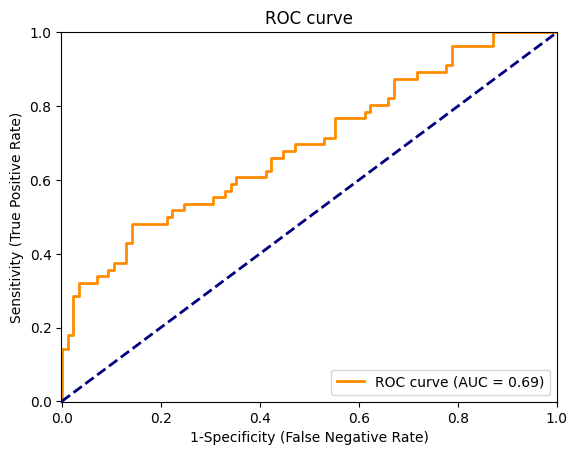

 AUC: 0.6928571428571428


In [ ]:
# Lets look at the model metrics
print('Metrics of the logistic regression model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

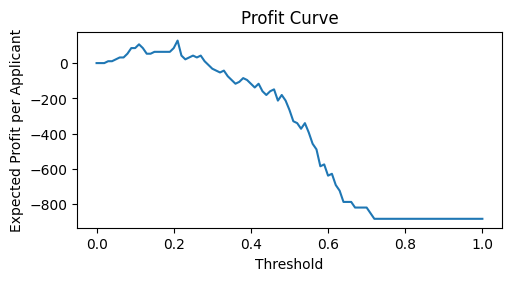

Max Profit: 127.65957446808511
Optimal Threshold: 0.21
Percentage Approved: 14.184397%
Accuracy: 0.5106382978723404
AUC: 0.6928571428571428


In [ ]:
# Calculate the testing set profit at each threshold and find the threshold that maximizes the profit
profit_all,max_profit,thr_max_profit,credit_percentage = calculate_max_profit_score(y_test,y_pred_prob,1)


#print('Max Profit: ',max_profit )
#print('Optimal Threshold: ',thr_max_profit)
#print('Percentage Approved',credit_percentage)

plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot(thr_all, profit_all)
plt.xlabel("Threshold")
plt.ylabel("Expected Profit per Applicant")
plt.title("Profit Curve")
plt.show()


# Use the threshold to classify the data in the test set
y_pred = np.where(y_pred_prob > thr_max_profit, 1, 0) # applying the threshold rule to classify

# Calculate accuracy
accuracy = custom_accuracy_score(y_test, y_pred)

# Calculate the area under the ROC curve
auc1 = roc_auc_score(y_test, y_pred_prob)
# Print stats
print_performance_stats(max_profit, thr_max_profit, credit_percentage, accuracy, auc1)

#Remember that Adjusting the threshold value according to the profit curve of the model does not affect the Area Under the Curve (AUC) of the ROC curve.

#Model №2: Random CART

In [ ]:
# Use Random CART to classify into categories (on train set!)
threshold = 0.3974 # CLUE: THINK what is the "correct" value


# Define a CART model and call it classifier_DT
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 21, random_state=77300) # random_state -- is same as random seed, neede to get the same result every time we rerun

# Train the model classifier_DT on the training data
classifier_DT.fit(X_train, y_train)

#  Use the trained model to predict testing data
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > threshold, 1, 0) # classification

print(y_pred_prob[0:5]) # first 5 probabilities
print(y_pred[0:5]) # resultant predicted classification
print(y_test[0:5]) # actual outcomes

#Putting threshold as 0.3974 gives us correct prediction for first 5

[0.96153846 0.96296296 0.32142857 0.016      0.52631579]
[1 1 0 0 1]
696     True
512     True
452    False
357    False
444     True
Name: Leave in less than 15 months, dtype: bool


CART tree with 21 leaf_nodes


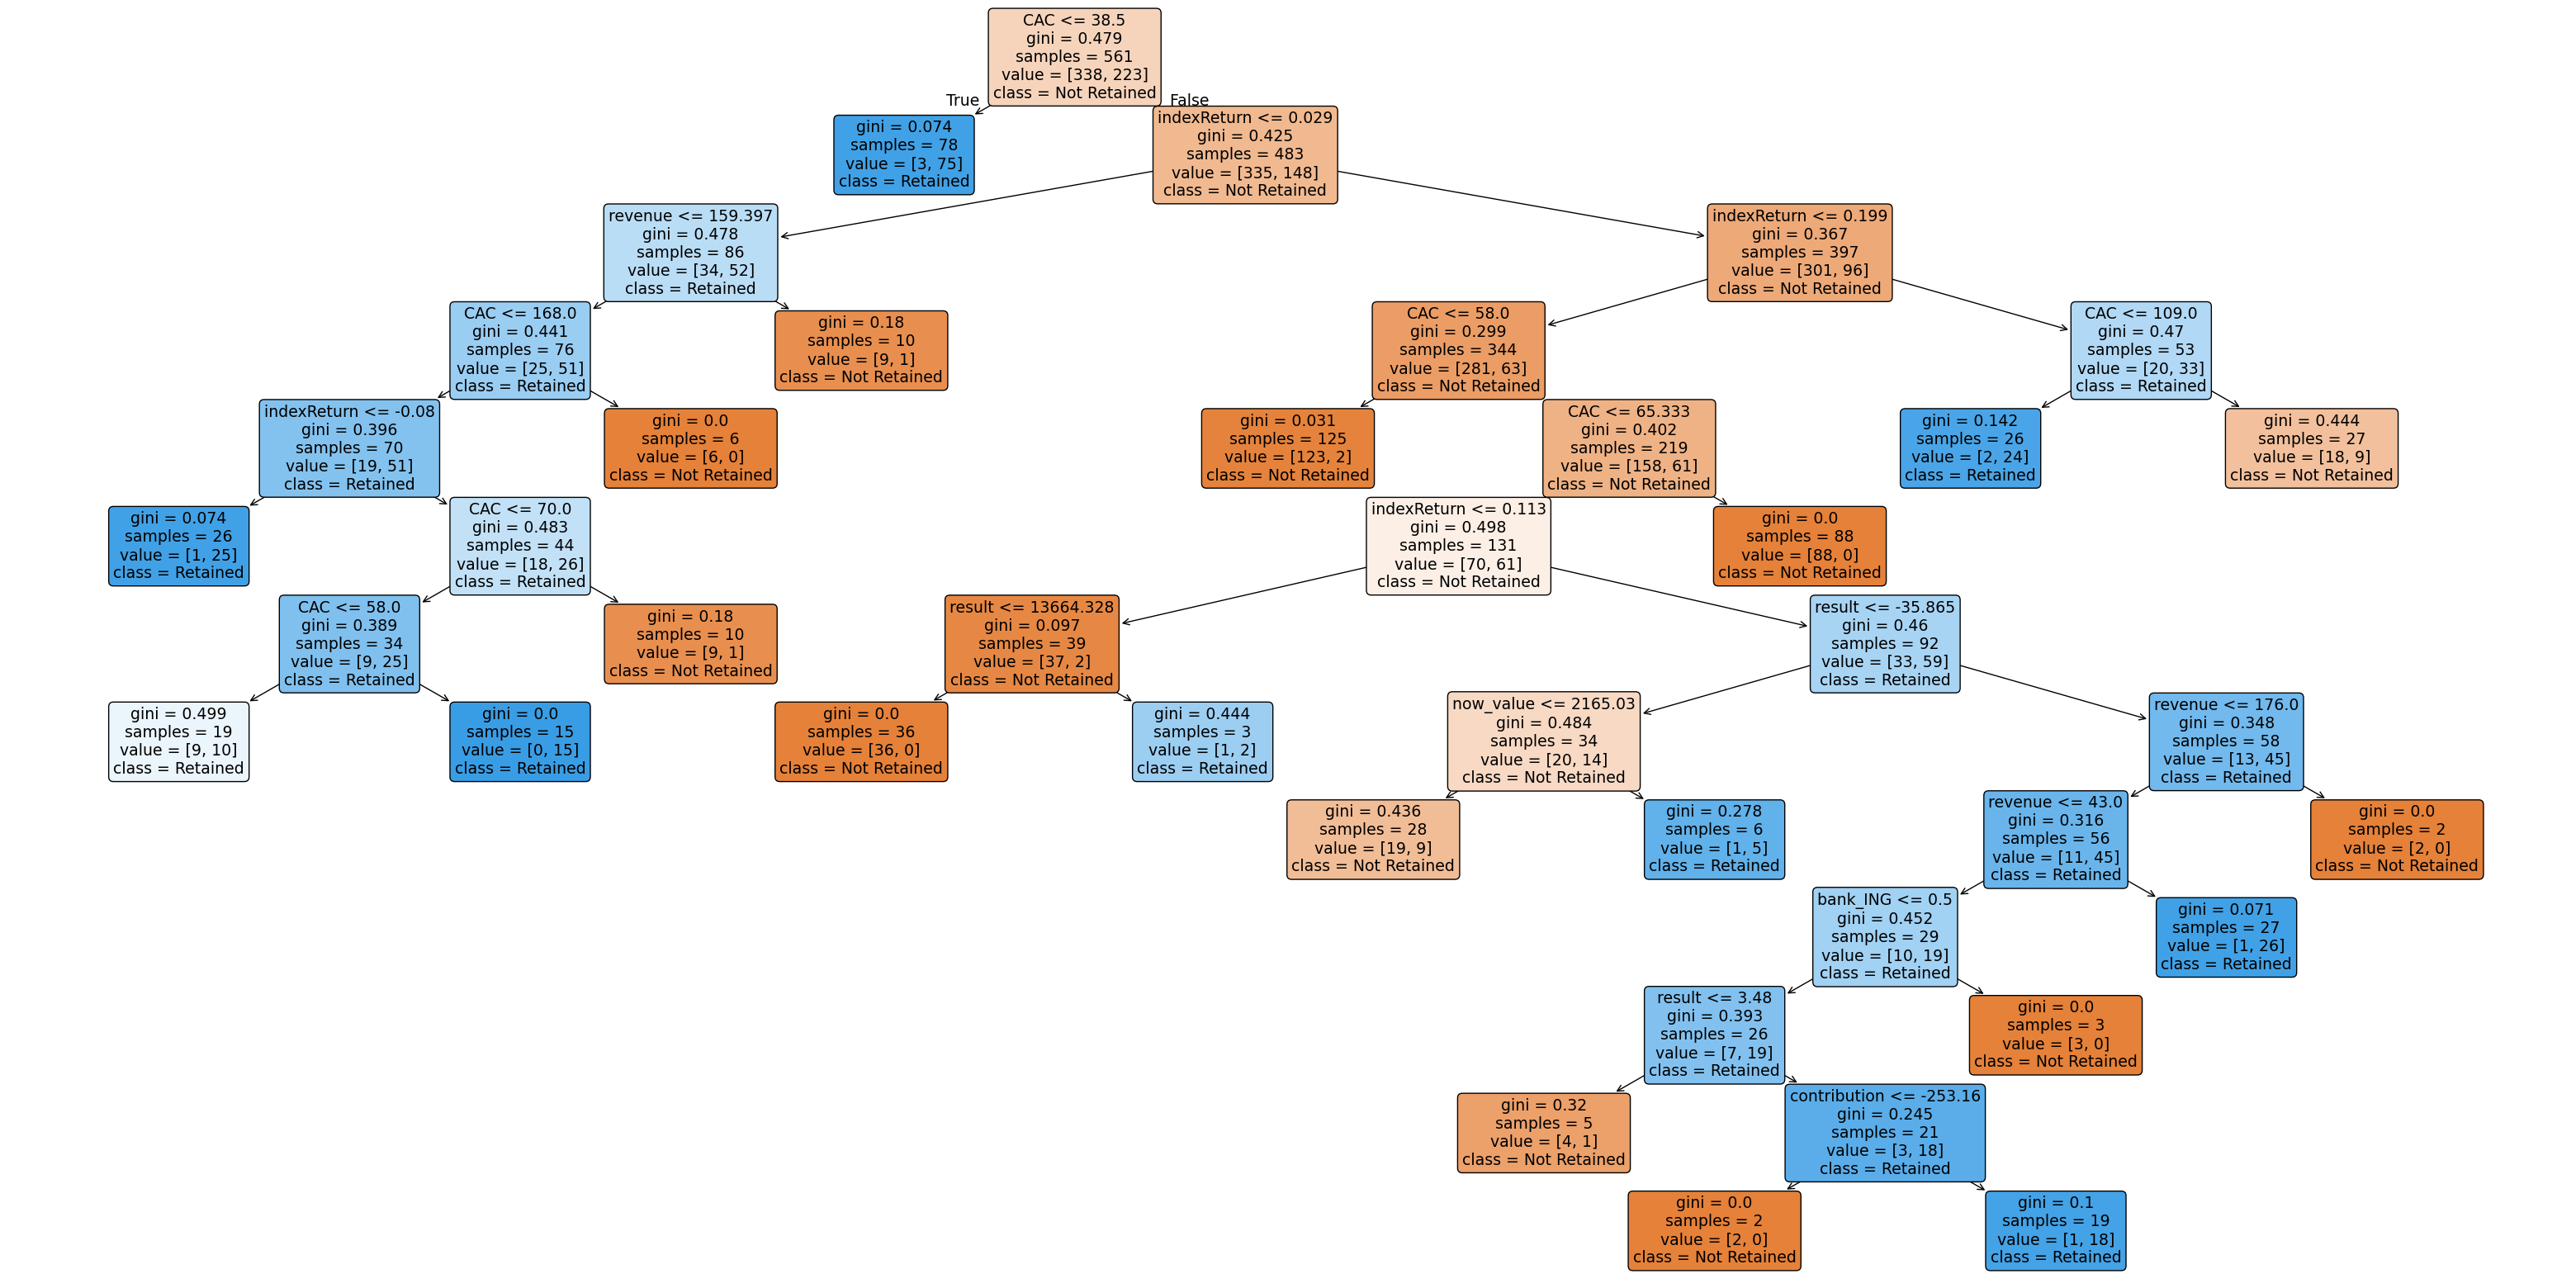

In [ ]:
# Visualizing the resultant tree

from sklearn import tree

plt.figure(figsize=(40,20))
tree.plot_tree(classifier_DT.fit(X_train, y_train), feature_names = X_train.columns, filled = True,
               class_names = ['Not Retained', 'Retained'], rounded = True)
print('CART tree with 21 leaf_nodes')

Hypertuning Random CART

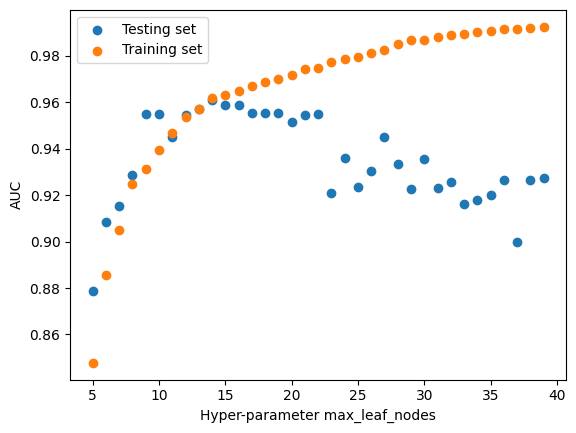

In [ ]:
# Tuning hyper-parameter max_leaf_nodes

n_max_leaf_nodes = range(5,40) # Lets train the models with 5, 6, 7, ... 40 leafs

# for each model calculate AUC for testing
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)

    y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
    y_pred = np.where(y_pred_prob > threshold, 1, 0)

    array.append([n,roc_auc_score(y_test, y_pred_prob)])

# plot the testing set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# now for each model calculate AUC on training
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)

    y_pred_prob = classifier_DT.predict_proba(X_train)[:,1]
    y_pred = np.where(y_pred_prob > threshold, 1, 0)

    array.append([n,roc_auc_score(y_train, y_pred_prob)])

# plot the training set AUCs
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# label the axes on the plot
plt.xlabel('Hyper-parameter max_leaf_nodes')
plt.ylabel('AUC')

# add the legend
plt.legend(['Testing set','Training set'])


In [ ]:
# Use Random CART to classify into categories (on train set!)
threshold = 0.3974 # CLUE: THINK what is the "correct" value


# Define a new CART model with hypertuned parameters and call it classifier_DT. the AUC starts to drop after 14 leafs
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 14, random_state=77300) # random_state -- is same as random seed, neede to get the same result every time we rerun.

# Train the model classifier_DT on the training data
classifier_DT.fit(X_train, y_train)

#  Use the trained model to predict testing data
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > threshold, 1, 0) # classification

print(y_pred_prob[0:5]) # first 5 probabilities
print(y_pred[0:5]) # resultant predicted classification
print(y_test[0:5]) # actual outcomes

[0.96153846 0.77586207 0.41176471 0.016      0.52631579]
[1 1 1 0 1]
696     True
512     True
452    False
357    False
444     True
Name: Leave in less than 15 months, dtype: bool


Sensitivity:  0.8928571428571429
Specificity:  0.8941176470588236


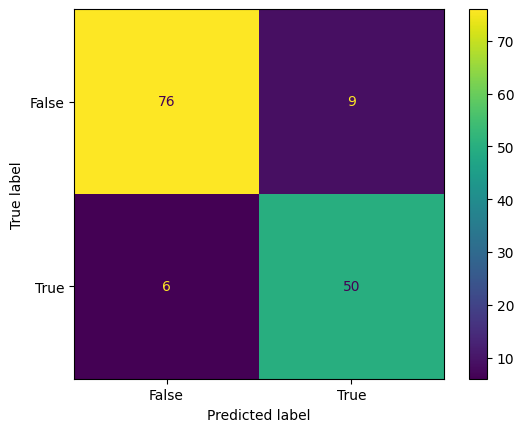

In [ ]:
# How good is the model's performance ?
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier_DT.classes_)
    disp.plot()

# Sensitivity calculation
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

plot_confusion_matrix(y_test, y_pred)
print("Sensitivity: ", custom_sensitivity_score(y_test,y_pred))
print("Specificity: ", custom_specificity_score(y_test, y_pred))

Metrics of CART

Confusion matrix: 
[[76  6]
 [ 9 50]]
                                       Accuracy: 0.8936170212765957
                       SENSITIVITY (aka RECALL): 0.8928571428571429
                     SPECIFICITY (aka FALL-OUT): 0.8941176470588236
 POSITIVE PREDICTIVE VALUE, PPV (aka PRECISION): 0.847457627118644
                 NEGATIVE PREDICTIVE VALUE, NPV: 0.926829268292683


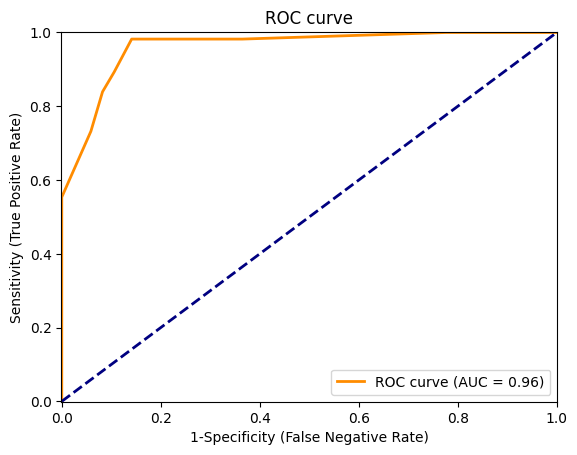

 AUC: 0.9609243697478992


In [ ]:
# Let's look at the model metrics
print('Metrics of CART\n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                       Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                       SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                     SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, PPV (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE, NPV: " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

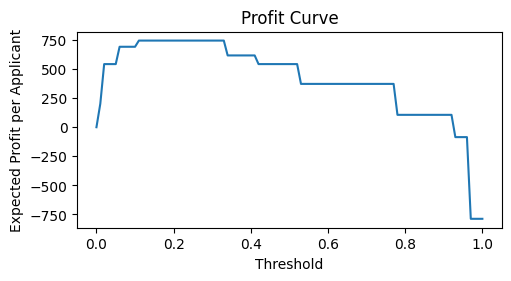

Max Profit: 744.6808510638298
Optimal Threshold: 0.11
Percentage Approved: 52.482270%
Accuracy: 0.9078014184397163
AUC: 0.9609243697478992


In [ ]:
# Calculate the testing set profit at each threshold and find the threshold that maximizes the profit
profit_all,max_profit,thr_max_profit,credit_percentage = calculate_max_profit_score(y_test,y_pred_prob,1)


#print('Max Profit: ',max_profit )
#print('Optimal Threshold: ',thr_max_profit)
#print('Percentage Approved',credit_percentage)

plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot(thr_all, profit_all)
plt.xlabel("Threshold")
plt.ylabel("Expected Profit per Applicant")
plt.title("Profit Curve")
plt.show()


# Use the threshold to classify the data in the test set
y_pred = np.where(y_pred_prob > thr_max_profit, 1, 0) # applying the threshold rule to classify

# Calculate accuracy
accuracy = custom_accuracy_score(y_test, y_pred)

# Calculate the area under the ROC curve
auc1 = roc_auc_score(y_test, y_pred_prob)
# Print stats
print_performance_stats(max_profit, thr_max_profit, credit_percentage, accuracy, auc1)

 Conclusion: Hypertuning CART shows Overfitting

#Model №3 Gradient Boosting Classifier

In [ ]:
classifier = GradientBoostingClassifier(random_state=77300)

# Training the classifier with our data
classifier.fit(X_train, y_train)

# Use the trained model to make predictions for the testing data
y_pred_prob = classifier.predict_proba(X_test)[:,1] # probabilities

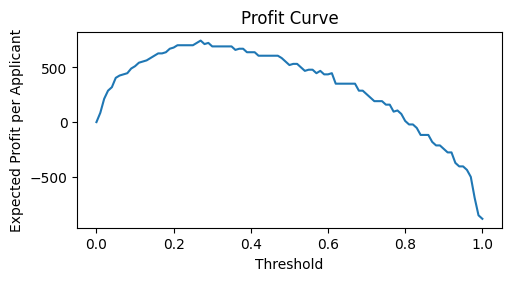

Max Profit: 744.6808510638298
Optimal Threshold: 0.27
Percentage Approved: 55.319149%
Accuracy: 0.9219858156028369
AUC: 0.9634453781512605


In [ ]:
# Calculate the testing set profit at each threshold and find the threshold that maximizes the profit
profit_all,max_profit,thr_max_profit,credit_percentage = calculate_max_profit_score(y_test,y_pred_prob,1)


#print('Max Profit: ',max_profit )
#print('Optimal Threshold: ',thr_max_profit)
#print('Percentage Approved',credit_percentage)

plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot(thr_all, profit_all)
plt.xlabel("Threshold")
plt.ylabel("Expected Profit per Applicant")
plt.title("Profit Curve")
plt.show()


# Use the threshold to classify the data in the test set
y_pred = np.where(y_pred_prob > thr_max_profit, 1, 0) # applying the threshold rule to classify

# Calculate accuracy
accuracy = custom_accuracy_score(y_test, y_pred)

# Calculate the area under the ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
# Print stats
print_performance_stats(max_profit, thr_max_profit, credit_percentage, accuracy, auc)

#Model №4: XGBOOST with fine tuned parameters

In [ ]:
import xgboost as xgb
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.8, 1.0, 1.2]
}

# Step : Initialize the XGBoost Model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Step : Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=2, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step : Evaluate the Results
print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]



Fitting 2 folds for each of 729 candidates, totalling 1458 fits
Best Hyperparameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 0.01, 'reg_lambda': 1.2}


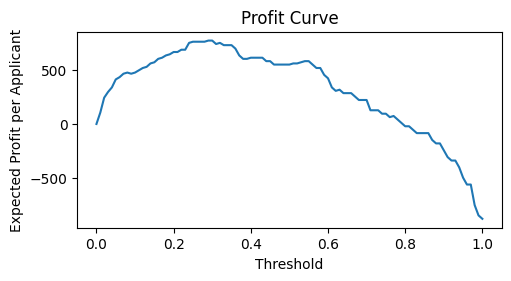

Max Profit: 776.5957446808511
Optimal Threshold: 0.29
Percentage Approved: 54.609929%
Accuracy: 0.9290780141843972
AUC: 0.9728991596638655


In [ ]:
# Calculate the testing set profit at each threshold and find the threshold that maximizes the profit
profit_all,max_profit,thr_max_profit,credit_percentage = calculate_max_profit_score(y_test,y_pred_prob,1)


#print('Max Profit: ',max_profit )
#print('Optimal Threshold: ',thr_max_profit)
#print('Percentage Approved',credit_percentage)

plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot(thr_all, profit_all)
plt.xlabel("Threshold")
plt.ylabel("Expected Profit per Applicant")
plt.title("Profit Curve")
plt.show()


# Use the threshold to classify the data in the test set
y_pred = np.where(y_pred_prob > thr_max_profit, 1, 0) # applying the threshold rule to classify

# Calculate accuracy
accuracy = custom_accuracy_score(y_test, y_pred)

# Calculate the area under the ROC curve
auc1 = roc_auc_score(y_test, y_pred_prob)
# Print stats
print_performance_stats(max_profit, thr_max_profit, credit_percentage, accuracy, auc1)

#Model №5: Artificial Neural Network ("Deep Learning") with TensorFlow

In [ ]:
model_name = "Neural_Network"
# conda install tensorflow keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#!pip install keras
#!pip install keras==2.12.0

#!pip uninstall tensorflow
#!pip install tensorflow==2.12.0
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

!pip install scikeras
from scikeras.wrappers import KerasClassifier

# Define the architecture and optimization metrics for the network
def create_model():
    model = keras.Sequential([
        layers.Dense(128, input_shape=(X_train.shape[1],), activation="relu", name="hidden-dense-128-layer-1"), #1st layer
        layers.Dropout(0.3),                                                                                    #2nd layer
        layers.Dense(64, activation="relu", name="hidden-dense-64-layer-2"),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid', name="output-layer"),                                             #last layer for classification
    ])
    adam = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])                             # define loss function and algorithm for optimization
    return model

nn_estimators = []
nn_estimators.append(('standardize', StandardScaler())) #scale the data
nn_estimators.append(('mlp', KerasClassifier(build_fn=create_model,   # compile the model
                                             epochs=30,               # how many complete passes to take over the training set, i.e., how many times to update the weights
                                             batch_size=128,          # how many data points are fed to the network at a time
                                             validation_split=0.2)))  # percentage of training data to keep for cross-validation

# Define the TensorFlow Neural Network model and give it a name
models[model_name] = Pipeline(nn_estimators, verbose=False)

# Train the model on the training data
models[model_name].fit(X_train, y_train)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5209 - loss: 0.7105 - val_accuracy: 0.6637 - val_loss: 0.6309
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6043 - loss: 0.7100 - val_accuracy: 0.6637 - val_loss: 0.6209
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6338 - loss: 0.6511 - val_accuracy: 0.6903 - val_loss: 0.6147
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6509 - loss: 0.6121 - val_accuracy: 0.6991 - val_loss: 0.6088
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6199 - loss: 0.6348 - val_accuracy: 0.7168 - val_loss: 0.6017
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6584 - loss: 0.6093 - val_accuracy: 0.7080 - val_loss: 0.5959
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7129 - loss: 0.5825 - val_accuracy: 0.6991 - val_loss: 0.5918
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7268 - loss: 0.5534 - val_accuracy: 0.7080 - val_loss: 0.5875


Pipeline(steps=[('standardize', StandardScaler()),
                ('mlp',
                 KerasClassifier(batch_size=128, build_fn=<function create_model at 0x7813b571a200>, epochs=30, validation_split=0.2))])

In [ ]:
# Use the trained model to make predictions for the testing data
y_pred_prob = models[model_name].predict_proba(X_test)[:,1] # probabilities

# Classify the data in the test set. Select the threshold value -- we will use the average probability of default in the training data
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

# Let's print the first five predictions and outcomes to get a first sense of how the model is doing
print(y_pred_prob[0:5]) # first 5 predicted probabilities
print(y_pred[0:5]) # resulting predicted classification
print(y_test[0:5]) # actual outcomes

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
[0.729817   0.6391881  0.10286172 0.09571162 0.8763002 ]
[1 1 0 0 1]
696     True
512     True
452    False
357    False
444     True
Name: Leave in less than 15 months, dtype: bool


Metrics of the Artificial Neural Network ("Deep Learning") Model with TensorFlow: 

Confusion matrix: 
[[57 25]
 [28 31]]
                                       Accuracy: 0.624113475177305
                       SENSITIVITY (aka RECALL): 0.5535714285714286
                     SPECIFICITY (aka FALL-OUT): 0.6705882352941176
 POSITIVE PREDICTIVE VALUE, PPV (aka PRECISION): 0.5254237288135594
                 NEGATIVE PREDICTIVE VALUE, NPV: 0.6951219512195121


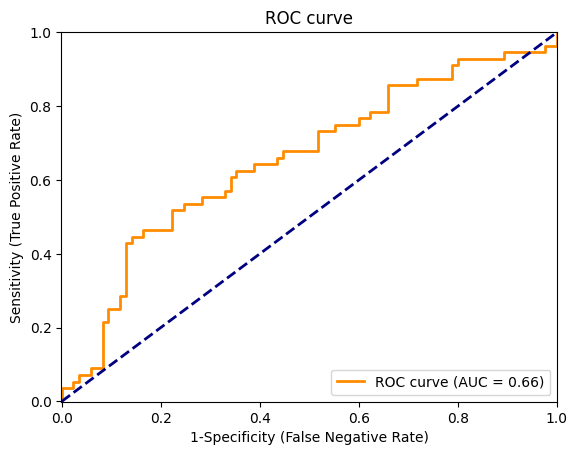

 AUC: 0.6567226890756303


In [ ]:
# Let's look at the model metrics
print('Metrics of the Artificial Neural Network ("Deep Learning") Model with TensorFlow: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                       Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                       SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                     SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, PPV (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE, NPV: " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

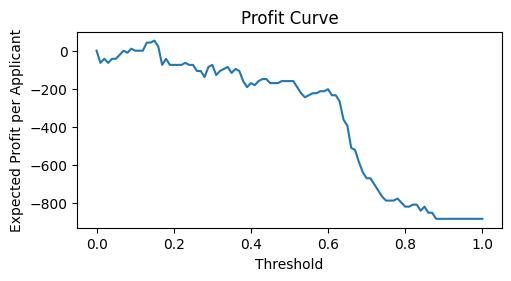

Max Profit: 53.191489361702125
Optimal Threshold: 0.15
Percentage Approved: 26.241135%
Accuracy: 0.5460992907801419
AUC: 0.6567226890756303


In [ ]:
# Calculate the testing set profit at each threshold and find the threshold that maximizes the profit
profit_all,max_profit,thr_max_profit,credit_percentage = calculate_max_profit_score(y_test,y_pred_prob,1)


#print('Max Profit: ',max_profit )
#print('Optimal Threshold: ',thr_max_profit)
#print('Percentage Approved',credit_percentage)

plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot(thr_all, profit_all)
plt.xlabel("Threshold")
plt.ylabel("Expected Profit per Applicant")
plt.title("Profit Curve")
plt.show()


# Use the threshold to classify the data in the test set
y_pred = np.where(y_pred_prob > thr_max_profit, 1, 0) # applying the threshold rule to classify

# Calculate accuracy
accuracy = custom_accuracy_score(y_test, y_pred)

# Calculate the area under the ROC curve
auc1 = roc_auc_score(y_test, y_pred_prob)
# Print stats
print_performance_stats(max_profit, thr_max_profit, credit_percentage, accuracy, auc1)

In [ ]:
# Write the results of the model into the "Models_Summary" table

Models_Summary.loc[model_name,"Max_profit"] = max_profit
Models_Summary.loc[model_name,"Percentage Approved"] = credit_percentage
Models_Summary.loc[model_name,"Optimal Threshold"] = thr_max_profit
Models_Summary.loc[model_name,"Accuracy"] = custom_accuracy_score(y_test, y_pred)
Models_Summary.loc[model_name,"Sensitivity"] = custom_sensitivity_score(y_test, y_pred)
Models_Summary.loc[model_name,"Specificity"] = custom_specificity_score(y_test, y_pred)
Models_Summary.loc[model_name,"PPV"] = custom_ppv_score(y_test, y_pred)
Models_Summary.loc[model_name,"NPV"] = custom_npv_score(y_test, y_pred)
Models_Summary.loc[model_name,"AUC"] = roc_auc_score(y_test, y_pred_prob)
Models_Summary

,AUC,Accuracy,Sensitivity,Specificity,PPV,NPV,Optimal Threshold,Percentage Approved,Max_profit
Neural_Network,0.656723,0.546099,0.857143,0.341176,0.461538,0.783784,0.15,26.241135,53.191489


## Summary for Tensor Flow Neural Net model
*   We trained the model with preset hyper-parameters and some fixed architecture
*   Applying the model on the testing set, we got AUC ~ 65.33
% -- not the worst, but not the best either
*   This should not discourage you: ANNs have an enormous number of tunable hyper-parameters, starting at the high level with the network architecture. Lots to experiment with and learn -- good luck!







#Model №6: Finetuned Hyperparameters of the Neural Network

Neural nets have several hyperparameters. Below we demonstrate finetuning two of them: number of epochs and batch size.

In [ ]:
# Hyper-parameter tuning for epochs and batch size using the function GridSearchCV for maximizing accuracy
model_name = "Grid_Search_Neural_Network"

#score_func = make_scorer(roc_auc_score, greater_is_better=True)

model = KerasClassifier(model=create_model, validation_split=0.2, verbose=0)

# Define the grid search parameters
batch_size = [64, 128, 256]
epochs = [10, 30, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# We will apply a 3-fold cross-validation. .
grid_search_NN = GridSearchCV(estimator=model, param_grid=param_grid, scoring = 'accuracy', return_train_score = True, cv=3)
grid_result = grid_search_NN.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

nn_estimators = []
nn_estimators.append(('standardize', StandardScaler())) #scale the data
nn_estimators.append(('mlp', KerasClassifier(build_fn=create_model,
                                             epochs=grid_search_NN.best_params_['epochs'],
                                             batch_size=grid_search_NN.best_params_['batch_size'],
                                             validation_split=0.2))) # compile the model

# Define the TensorFlow Neural Network model and give it a name
models[model_name] = Pipeline(nn_estimators, verbose=False)

# Train the model on the training data
models[model_name].fit(X_train, y_train)

Best: 0.645276 using {'batch_size': 128, 'epochs': 50}
0.604278 (0.011552) with: {'batch_size': 64, 'epochs': 10}
0.525847 (0.067689) with: {'batch_size': 64, 'epochs': 30}
0.643494 (0.024048) with: {'batch_size': 64, 'epochs': 50}
0.613191 (0.032184) with: {'batch_size': 128, 'epochs': 10}
0.618538 (0.018178) with: {'batch_size': 128, 'epochs': 30}
0.645276 (0.028409) with: {'batch_size': 128, 'epochs': 50}
0.611408 (0.020634) with: {'batch_size': 256, 'epochs': 10}
0.607843 (0.029072) with: {'batch_size': 256, 'epochs': 30}
0.607843 (0.041269) with: {'batch_size': 256, 'epochs': 50}
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5249 - loss: 0.7363 - val_accuracy: 0.6106 - val_loss: 0.6589
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6015 - loss: 0.6941 - val_accuracy: 0.6195 - val_loss: 0.6456
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5879 - loss: 0.6647 - val_accuracy: 0.6195 - val_loss: 0.6350
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━

Pipeline(steps=[('standardize', StandardScaler()),
                ('mlp',
                 KerasClassifier(batch_size=128, build_fn=<function create_model at 0x7813b571a200>, epochs=50, validation_split=0.2))])

In [ ]:
# Use the trained model to make predictions for the testing data
y_pred_prob = models[model_name].predict_proba(X_test)[:,1] # probabilities

# Classify the data in the test set. Select the threshold value -- we will use the average probability of default in the training data
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

# Let's print the first five predictions and outcomes to get a first sense of how the model is doing
print(y_pred_prob[0:5]) # first 5 predicted probabilities
print(y_pred[0:5]) # resulting predicted classification
print(y_test[0:5]) # actual outcomes

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[0.61869687 0.6289689  0.08448642 0.06461538 0.9055552 ]
[1 1 0 0 1]
696     True
512     True
452    False
357    False
444     True
Name: Leave in less than 15 months, dtype: bool


Metrics of the Finetuned Artificial Neural Network ("Deep Learning") with TensorFlow Model: 

Confusion matrix: 
[[59 23]
 [26 33]]
                                       Accuracy: 0.6524822695035462
                       SENSITIVITY (aka RECALL): 0.5892857142857143
                     SPECIFICITY (aka FALL-OUT): 0.6941176470588235
 POSITIVE PREDICTIVE VALUE, PPV (aka PRECISION): 0.559322033898305
                 NEGATIVE PREDICTIVE VALUE, NPV: 0.7195121951219512


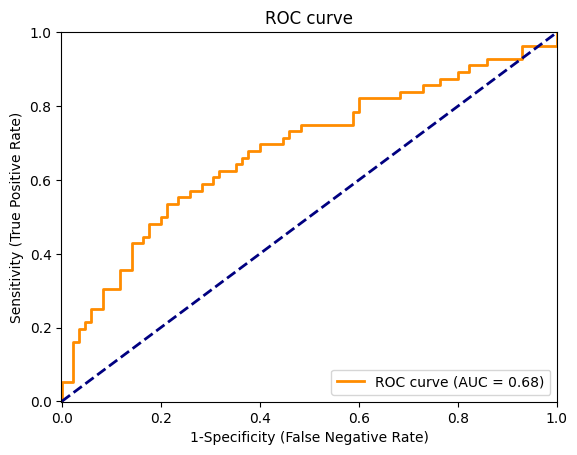

 AUC: 0.6810924369747899


In [ ]:
# Let's look at the model metrics
print('Metrics of the Finetuned Artificial Neural Network ("Deep Learning") with TensorFlow Model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                       Accuracy: " + str(custom_accuracy_score(y_test, y_pred)))
print("                       SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                     SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, PPV (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE, NPV: " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

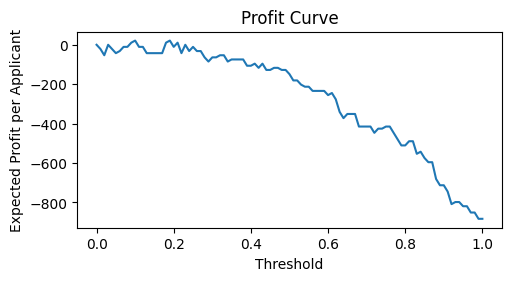

Max Profit: 21.27659574468085
Optimal Threshold: 0.1
Percentage Approved: 29.787234%
Accuracy: 0.5531914893617021
AUC: 0.6810924369747899


In [ ]:
# Calculate the testing set profit at each threshold and find the threshold that maximizes the profit
profit_all,max_profit,thr_max_profit,credit_percentage = calculate_max_profit_score(y_test,y_pred_prob,1)


#print('Max Profit: ',max_profit )
#print('Optimal Threshold: ',thr_max_profit)
#print('Percentage Approved',credit_percentage)

plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot(thr_all, profit_all)
plt.xlabel("Threshold")
plt.ylabel("Expected Profit per Applicant")
plt.title("Profit Curve")
plt.show()


# Use the threshold to classify the data in the test set
y_pred = np.where(y_pred_prob > thr_max_profit, 1, 0) # applying the threshold rule to classify

# Calculate accuracy
accuracy = custom_accuracy_score(y_test, y_pred)

# Calculate the area under the ROC curve
auc1 = roc_auc_score(y_test, y_pred_prob)
# Print stats
print_performance_stats(max_profit, thr_max_profit, credit_percentage, accuracy, auc1)

In [ ]:
# Write the results of the model into the "Models_Summary" table

Models_Summary.loc[model_name,"Max_profit"] = max_profit
Models_Summary.loc[model_name,"Percentage Approved"] = credit_percentage
Models_Summary.loc[model_name,"Optimal Threshold"] = thr_max_profit
Models_Summary.loc[model_name,"Accuracy"] = custom_accuracy_score(y_test, y_pred)
Models_Summary.loc[model_name,"Sensitivity"] = custom_sensitivity_score(y_test, y_pred)
Models_Summary.loc[model_name,"Specificity"] = custom_specificity_score(y_test, y_pred)
Models_Summary.loc[model_name,"PPV"] = custom_ppv_score(y_test, y_pred)
Models_Summary.loc[model_name,"NPV"] = custom_npv_score(y_test, y_pred)
Models_Summary.loc[model_name,"AUC"] = roc_auc_score(y_test, y_pred_prob)
Models_Summary

,AUC,Accuracy,Sensitivity,Specificity,PPV,NPV,Optimal Threshold,Percentage Approved,Max_profit
Neural_Network,0.656723,0.546099,0.857143,0.341176,0.461538,0.783784,0.15,26.241135,53.191489
Grid_Search_Neural_Network,0.681092,0.553191,0.821429,0.376471,0.464646,0.761905,0.1,29.787234,21.276596


#Summary of the implemented neural network models

In [ ]:
Models_Summary.loc[:,"AUC":].sort_values(by='Max_profit', ascending=False)

,AUC,Accuracy,Sensitivity,Specificity,PPV,NPV,Optimal Threshold,Percentage Approved,Max_profit
Neural_Network,0.656723,0.546099,0.857143,0.341176,0.461538,0.783784,0.15,26.241135,53.191489
Grid_Search_Neural_Network,0.681092,0.553191,0.821429,0.376471,0.464646,0.761905,0.1,29.787234,21.276596


# Model XGBoost with finetuned hyperparameters shows the best performance metrics of of all the models tested for the classification. Therefore using XGBOOST to make the predictions for our client.

In [ ]:
clean_predict = clean_predict.dropna()
clean_predict.shape

(3218, 71)

In [ ]:
cust_ID = clean_predict['idClient']

In [ ]:
X_pilot= clean_predict.drop(columns = ['idClient','Leave in less than 15 months']).iloc[:3218]

X_pilot.shape


(3218, 69)

In [ ]:
y_pred_prob = best_model.predict_proba(X_pilot)[:, 1]

y_pred = np.where(y_pred_prob > thr_max_profit, 1, 0) # applying the threshold rule to classify
# Lets add the ID column to know "who is who"
Prediction = pd.DataFrame(data={"Customer_id": cust_ID,"Likely_to_leave":y_pred})
Prediction.head(100)

,Customer_id,Likely_to_leave
0,1,0
1,2,0
2,4,0
3,5,0
4,7,0
...,...,...
95,132,0
96,133,0
97,134,0
98,135,0


In [ ]:
print(y_pred_prob)

[0.00425066 0.00133508 0.00715637 ... 0.920227   0.8702927  0.9507692 ]


In [ ]:
# Lets add the ID column to know "who is who"
Prediction = pd.DataFrame(data={"Customer_id": cust_ID,"Likely_to_leave":y_pred})

#Export the predictions into a CSV file
Prediction.to_csv("Predicted_result.csv",sep = ',', index=False)
files.download("Predicted_result.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>